# 2023/24 - LSTM

This notebook is a implementation of a **LSTM** for Driving Behavior Classification. The model is trained on the [IPL-Dataset](http://www.robesafe.uah.es/personal/eduardo.romera/uah-driveset/) dataset. 

The dataset contains recorded driving scenarios like Intersections, Acceleration, Brake. The dataset is divided into 3 classes: **Slow, Normal and Aggressive**.

Each driving scenario is represented by a sequence of sensor data. The sensor data is collected from the following sensors:
- Accelerometer
- Gyroscope
- GPS


## Libraries

## Directories

In [7]:
import os

# Make auxiliar folders
if not os.path.exists('runtime_saves'):
    os.makedirs('runtime_saves')
if not os.path.exists('runtime_saves/models'):
    os.makedirs('runtime_saves/models')
if not os.path.exists('runtime_saves/train&test'):
    os.makedirs('runtime_saves/train&test')
    
current_dir = os.getcwd()

root_dir = os.path.abspath(os.path.join(current_dir, os.pardir, os.pardir))

datasets_dir = os.path.join(root_dir, 'datasets')

dataset_dir = os.path.join(datasets_dir, 'IPL-Dataset')


print(f'Root directory: {root_dir}')
print(f'Datasets directory: {datasets_dir}')
print(f'Dataset directory: {dataset_dir}')

Root directory: c:\codeUni\ProjetoInformatico\CoEProject-AI-DrivingClassification
Datasets directory: c:\codeUni\ProjetoInformatico\CoEProject-AI-DrivingClassification\datasets
Dataset directory: c:\codeUni\ProjetoInformatico\CoEProject-AI-DrivingClassification\datasets\IPL-Dataset


# **Data Preprocessing**

## Data structure:
- Acceleration (m/s2): X, Y, Z Axis 

- Gyroscope (°/s): X, Y, Z Axis

- GPS: Latitude and Longitude 

## Load dataset and apply rolling window

In [8]:
import json
import pandas as pd
import numpy as np

def apply_rolling_window(df):
    """
    Apply a centered rolling mean with a window of 3 to each column of the DataFrame.
    For each value, the function computes the mean of the value itself, the one before, and the one after.
    """
    df = df.rolling(window=3, center=True, min_periods=1).mean()    
    
    return df

directories = ['Acceleration', 'Brake', 'Intersection']
column_names = ['accelerometerXAxis', 'accelerometerYAxis', 'accelerometerZAxis', 'gyroscopeXAxis', 'gyroscopeYAxis', 'gyroscopeZAxis', 'Latitude', 'Longitude']

data_bmw = pd.DataFrame(columns=column_names)
labels_bmw = []
data_honda = pd.DataFrame(columns=column_names)
labels_honda = []

label_names = []



# delete = None
# delete_rolling = None

# \datasets\IPL-Dataset\Acceleration\Till reached distance\10m\aggressive\BMW e36
test_file = os.path.join(dataset_dir, 'Acceleration', 'Till reached distance', '10m', 'aggressive', 'BMW e36', 'acceleration 0m 10m aggressive-23-04-2023-19-42-30.json')

# print head
print('Test file')
test_data = json.load(open(test_file))
test_data = test_data['capturedData']
test_data = pd.DataFrame(test_data)
print(test_data.head())
test_data.to_csv('runtime_saves/test_data.csv', index=False)

# Apply rolling window
test_data_rolling = apply_rolling_window(test_data[['accelerometerXAxis', 'accelerometerYAxis', 'accelerometerZAxis', 'gyroscopeXAxis', 'gyroscopeYAxis', 'gyroscopeZAxis']])
delete_rolling = test_data_rolling
delete_rolling.to_csv('runtime_saves/delete_rolling.csv', index=False)

test_data[['accelerometerXAxis', 'accelerometerYAxis', 'accelerometerZAxis', 'gyroscopeXAxis', 'gyroscopeYAxis', 'gyroscopeZAxis']] = test_data_rolling

# print head
print('Test file after rolling window')
print(test_data.head())
test_data.to_csv('runtime_saves/test_data_rolling.csv', index=False)

# TODO Import other folders too

for directory in directories:
    for root, dirs, files in os.walk(os.path.join(dataset_dir, directory)):
        if 'turn 90 degree constant speed' in root: # Skip this directory
            continue
        for file in files:
            if file.endswith('.json'):
                car = os.path.basename(root).split()[0].upper()            
                label = os.path.basename(os.path.dirname(root))
                # print(f'Processing: {car} : {label} : {directory} : {file}')
                
                file_data = json.load(open(os.path.join(root, file)))
                file_data = file_data['capturedData']
                file_data = pd.DataFrame(file_data)
                # print('File data')
                # print(file_data.head())
                # # save to csv
                # delete = file_data
                # delete.to_csv('runtime_saves/delete.csv', index=False)
                
                
                # Rename speed Km/h to speed
                file_data.rename(columns={'speed Km/h': 'speed'}, inplace=True)
                file_data.rename(columns={'speedKmh': 'speed'}, inplace=True)
                
                file_data.drop(['speed'], axis=1, inplace=True, errors='ignore')
                
                 # Drop timestamp
                file_data = file_data.drop(['createdAt'], axis=1, errors='ignore')
                file_data = file_data.drop(['timestamp'], axis=1, errors='ignore')   
                file_data = file_data.drop(['id'], axis=1, errors='ignore')
                
                # Apply rolling window
                file_data_rolling = apply_rolling_window(file_data[['accelerometerXAxis', 'accelerometerYAxis', 'accelerometerZAxis', 'gyroscopeXAxis', 'gyroscopeYAxis', 'gyroscopeZAxis']])
                delete_rolling = file_data_rolling
                delete_rolling.to_csv('runtime_saves/delete_rolling.csv', index=False)
                
                file_data[['accelerometerXAxis', 'accelerometerYAxis', 'accelerometerZAxis', 'gyroscopeXAxis', 'gyroscopeYAxis', 'gyroscopeZAxis']] = file_data_rolling
    
                labels = np.full((file_data.shape[0], 1), label)
                
                column_names = file_data.columns
                # print(f'Column names: {column_names}')
                
                # If data is empty, create a new dataframe with the column names
                if data_bmw.empty:
                    data_bmw = pd.DataFrame(columns=column_names)
                    # print(f'Data BMW shape: {data_bmw.shape}')
                if data_honda.empty:
                    data_honda = pd.DataFrame(columns=column_names)
                    # print(f'Data HONDA shape: {data_honda.shape}')
                
                if car == 'BMW':                                      
                    data_bmw = pd.concat([data_bmw, file_data.copy()], axis=0)
                    # print(f'Data BMW shape: {data_bmw.shape}')
                    
                    labels_bmw += labels.tolist()
                    # print(f'Labels BMW shape: {len(labels_bmw)}')
                    
                elif car == 'HONDA':
                    data_honda = pd.concat([data_honda, file_data.copy()], axis=0)
                    # print(f'Data HONDA shape: {data_honda.shape}')
                    
                    labels_honda += labels.tolist()
                    # print(f'Labels HONDA shape: {len(labels_honda)}')
                    
# Show data shapes      
print(f'BMW Data shape: {data_bmw.shape}')
print(f'BMW Labels shape: {len(labels_bmw)}')
print(f'Honda Data shape: {data_honda.shape}')
print(f'Honda Labels shape: {len(labels_honda)}')

# Show unique labels
print(f'BMW Labels: {np.unique(labels_bmw)}')
print(f'Honda Labels: {np.unique(labels_honda)}')
label_names = np.unique(labels_bmw)

# Save Data to CSV - runtime_saves folder
data_bmw.to_csv('runtime_saves/bmw_data.csv', index=False)
data_honda.to_csv('runtime_saves/honda_data.csv', index=False)
labels_bmw = np.array(labels_bmw)
labels_honda = np.array(labels_honda)

# Save Labels to CSV - runtime_saves folder
np.savetxt('runtime_saves/bmw_labels.csv', labels_bmw, delimiter=',', fmt='%s')
np.savetxt('runtime_saves/honda_labels.csv', labels_honda, delimiter=',', fmt='%s')


Test file
    id  accelerometerXAxis  accelerometerYAxis  accelerometerZAxis  \
0  636            0.204224            0.574472            0.015077   
1  637            0.230342            0.175526            0.122981   
2  638            0.199742            1.303585           -0.188207   
3  639            0.003083            0.753614            0.103433   
4  640            0.202767            0.281722            0.290354   

   gyroscopeXAxis  gyroscopeYAxis  gyroscopeZAxis   Latitude  Longitude  \
0        0.001833        0.006720        0.003054  39.806938  -8.620294   
1       -0.000611        0.000000       -0.002443  39.806938  -8.620294   
2        0.014661       -0.013439       -0.003054  39.806938  -8.620294   
3        0.034208       -0.011606       -0.011606  39.806938  -8.620294   
4        0.023213       -0.015272       -0.036652  39.806938  -8.620294   

   speed Km/h                      createdAt  
0         0.0  2023-04-23T19:42:30.793+01:00  
1         0.0  2023-04-2

C:\Users\PDesktop\AppData\Local\Temp\ipykernel_8032\69872694.py:106: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  data_bmw = pd.concat([data_bmw, file_data.copy()], axis=0)
C:\Users\PDesktop\AppData\Local\Temp\ipykernel_8032\69872694.py:113: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  data_honda = pd.concat([data_honda, file_data.copy()], axis=0)


BMW Data shape: (3001, 8)
BMW Labels shape: 3001
Honda Data shape: (1081, 8)
Honda Labels shape: 1081
BMW Labels: ['aggressive' 'normal' 'slow']
Honda Labels: ['aggressive' 'normal' 'slow']


In [9]:
import numpy as np
import pandas as pd

# Load the dataset into a DataFrame
df_bmw = pd.read_csv('runtime_saves/bmw_data.csv')
df_honda = pd.read_csv('runtime_saves/honda_data.csv')

# Load the labels into a NumPy array
labels_bmw = np.loadtxt('runtime_saves/bmw_labels.csv', delimiter=',', dtype=str)
labels_honda = np.loadtxt('runtime_saves/honda_labels.csv', delimiter=',', dtype=str)

labels = np.concatenate([labels_bmw, labels_honda], axis=0)

## Show Labels

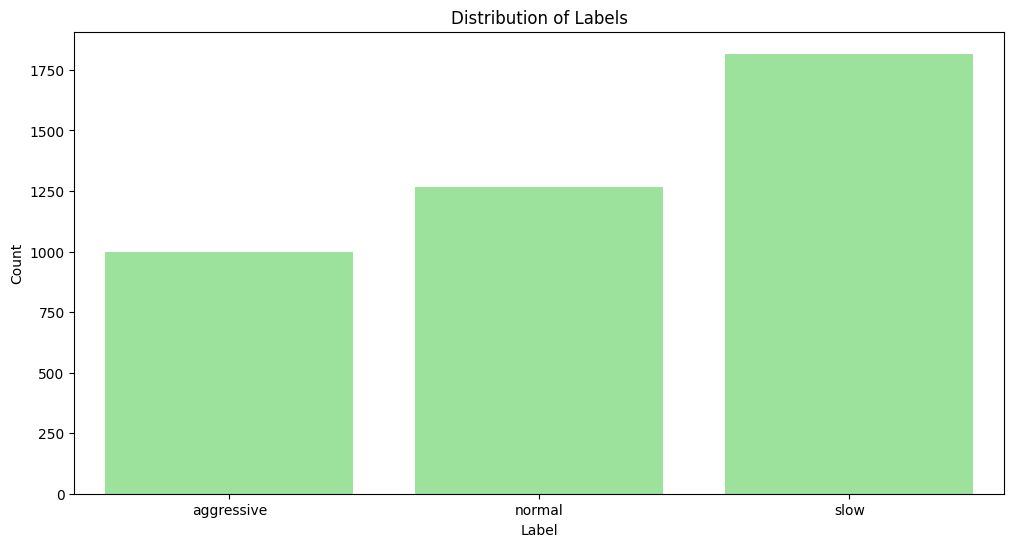

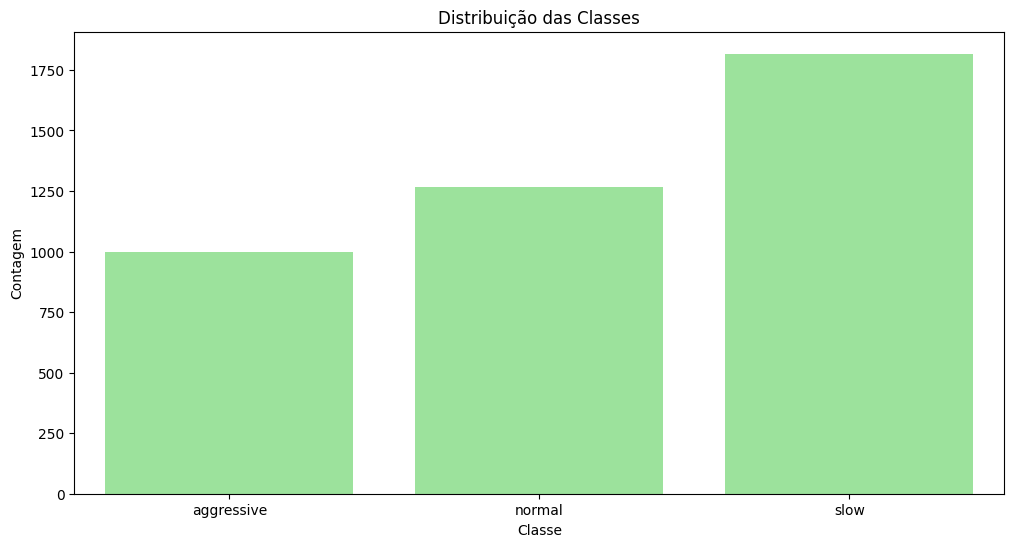

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

labels = pd.Series(labels)

# plot the count of each label
plt.figure(figsize=(12, 6))
sns.countplot(x=labels, color='lightgreen')
plt.title('Distribution of Labels')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()


plt.figure(figsize=(12, 6))
sns.countplot(x=labels, color='lightgreen')
plt.title('Distribuição das Classes')
plt.xlabel('Classe')
plt.ylabel('Contagem')
plt.show()

## Label Encoding

In [11]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()

labels = label_encoder.fit_transform(labels)

## Normalization

In [12]:
def normalize_between_0_and_1(data, columns):
    for column in columns:
        if column not in data.columns:
            print(f"[WARNING] {column} not found in DataFrame.")
            continue
        else:
            max_value = np.max(data[column])
            min_value = np.min(data[column])
            data[column] = (data[column] - min_value) / (max_value - min_value)
    return data

columns_to_normalize = ['accelerometerXAxis', 'accelerometerYAxis', 'accelerometerZAxis', 'gyroscopeXAxis', 'gyroscopeYAxis', 'gyroscopeZAxis']

print('BMW data before normalization')
print(df_bmw.head())

df_bmw = normalize_between_0_and_1(df_bmw, columns_to_normalize)
df_honda = normalize_between_0_and_1(df_honda, columns_to_normalize)

print('BMW data after normalization')
print(df_bmw.head())


test_data_2 = normalize_between_0_and_1(test_data_rolling, columns_to_normalize)
print('Test data after normalization')
test_data_2.to_csv('runtime_saves/test_data_2.csv', index=False)

BMW data before normalization
   accelerometerXAxis  accelerometerYAxis  accelerometerZAxis  gyroscopeXAxis  \
0            0.217283            0.374999            0.069029        0.000611   
1            0.211436            0.684528           -0.016716        0.005294   
2            0.144389            0.744242            0.012736        0.016086   
3            0.135198            0.779640            0.068527        0.024027   
4            0.054488            0.322867            0.121088        0.019344   

   gyroscopeYAxis  gyroscopeZAxis   Latitude  Longitude  
0        0.003360        0.000305  39.806938  -8.620294  
1       -0.002240       -0.000814  39.806938  -8.620294  
2       -0.008348       -0.005701  39.806938  -8.620294  
3       -0.013439       -0.017104  39.806938  -8.620294  
4       -0.010181       -0.030136  39.806938  -8.620294  
BMW data after normalization
   accelerometerXAxis  accelerometerYAxis  accelerometerZAxis  gyroscopeXAxis  \
0            0.637167    

## Concatenate Data

In [13]:
df = pd.concat([df_bmw, df_honda], axis=0)

# create label column in the dataframe
df['label'] = labels

print(df.head())

   accelerometerXAxis  accelerometerYAxis  accelerometerZAxis  gyroscopeXAxis  \
0            0.637167            0.847469            0.226415        0.361504   
1            0.635849            0.874252            0.213532        0.377372   
2            0.620730            0.879419            0.217957        0.413936   
3            0.618658            0.882482            0.226339        0.440842   
4            0.600458            0.842958            0.234237        0.424974   

   gyroscopeYAxis  gyroscopeZAxis   Latitude  Longitude  label  
0        0.590126        0.448040  39.806938  -8.620294      0  
1        0.569078        0.447157  39.806938  -8.620294      0  
2        0.546116        0.443302  39.806938  -8.620294      0  
3        0.526980        0.434308  39.806938  -8.620294      0  
4        0.539227        0.424028  39.806938  -8.620294      0  


## Create Sequences

In [14]:
import numpy as np
from scipy.stats import mode

def create_dataset(data, labels, window_size=16, step_size=2):
    X, y = [], []
    for i in range(0, len(data) - window_size + 1, step_size):
        # Create the window of data
        X.append(data[i:i + window_size].values)        
        
         # Find the most frequent string label in the current window
        window_labels = labels[i:i + window_size]
        most_frequent_label = mode(window_labels, axis=None)[0]
        
        # Add the most frequent label as the label of the current window
        y.append(most_frequent_label)
            
    return np.array(X), np.array(y)

time_steps = 16
step_size = 1

X, y = create_dataset(
    df[['accelerometerXAxis', 'accelerometerYAxis', 'accelerometerZAxis',
                   'gyroscopeXAxis', 'gyroscopeYAxis', 'gyroscopeZAxis', 'Latitude', 'Longitude']],
    df['label'],
    window_size=time_steps,
    step_size=step_size    
)

print(f'X shape: {X.shape}')
print(f'y shape: {y.shape}')

# save the data to a npy
np.save('runtime_saves/X.npy', X)
np.savetxt('runtime_saves/y.csv', y, delimiter=',', fmt='%d')

X shape: (4067, 16, 8)
y shape: (4067,)


# Split Dataset for Model Training
- 70% Training
- 20% Test
- 10% Validation

In [15]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, stratify=y, random_state=23)
X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=0.1, shuffle=True, stratify=y_train, random_state=23)

print(f'X_train shape: {X_train.shape}')
print(f'y_train shape: {y_train.shape}\n')
print(f'X_test shape: {X_test.shape}')
print(f'y_test shape: {y_test.shape}\n')
print(f'X_validation shape: {X_validation.shape}')
print(f'y_validation shape: {y_validation.shape}')


X_train shape: (2927, 16, 8)
y_train shape: (2927,)

X_test shape: (814, 16, 8)
y_test shape: (814,)

X_validation shape: (326, 16, 8)
y_validation shape: (326,)


In [16]:
# from tensorflow.keras import backend as K

# K.clear_session()

# **MODEL ARCHITECTURE** - Stacked LSTM

In [17]:
from tensorflow import keras
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization

# Inputs
input_shape = (X_train.shape[1], X_train.shape[2])
inputs = keras.Input(shape=input_shape)

# Architecture
x = LSTM(64, return_sequences=True)(inputs)
x = BatchNormalization()(x)

x = LSTM(64, return_sequences=True)(x)
x = BatchNormalization()(x)

x = LSTM(64)(x)
x = BatchNormalization()(x)

outputs = Dense(3, activation='softmax')(x)

# Create the model
model = keras.Model(inputs=inputs, outputs=outputs)

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 16, 8)]           0         
                                                                 
 lstm (LSTM)                 (None, 16, 64)            18688     
                                                                 
 batch_normalization (Batch  (None, 16, 64)            256       
 Normalization)                                                  
                                                                 
 lstm_1 (LSTM)               (None, 16, 64)            33024     
                                                                 
 batch_normalization_1 (Bat  (None, 16, 64)            256       
 chNormalization)                                                
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024 

## Compile Model

In [52]:
from tensorflow.keras import optimizers

# model.compile(optimizer=optimizers.Adam(learning_rate=0.01), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

## Train Model

In [53]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

learning_rate_reduction = ReduceLROnPlateau(
    monitor='val_accuracy', 
    patience=7, 
    verbose=1, 
    factor=0.5, 
    min_lr=1e-8)

early_stop = EarlyStopping(monitor='val_accuracy',
                           patience=35,
                           restore_best_weights=True)
model_checkpoint = ModelCheckpoint('models/checkpoints/StackedLSTM-cp.h5', save_best_only=True)


history = model.fit(
    X_train, y_train,
    epochs=150,
    batch_size=16,
    validation_data=(X_validation, y_validation),
    callbacks=[model_checkpoint, learning_rate_reduction, early_stop])

Epoch 1/150
183/183 [==============================] - 11s 23ms/step - loss: 1.0305 - accuracy: 0.4985 - val_loss: 1.2626 - val_accuracy: 0.3098 - lr: 0.0010
Epoch 2/150
  9/183 [>.............................] - ETA: 2s - loss: 0.8928 - accuracy: 0.6111

c:\Users\PDesktop\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


183/183 [==============================] - 3s 15ms/step - loss: 0.8964 - accuracy: 0.5808 - val_loss: 2.3341 - val_accuracy: 0.2546 - lr: 0.0010
Epoch 3/150
183/183 [==============================] - 3s 15ms/step - loss: 0.8268 - accuracy: 0.6061 - val_loss: 4.2811 - val_accuracy: 0.2546 - lr: 0.0010
Epoch 4/150
183/183 [==============================] - 3s 15ms/step - loss: 0.7867 - accuracy: 0.6437 - val_loss: 3.3709 - val_accuracy: 0.2546 - lr: 0.0010
Epoch 5/150
183/183 [==============================] - 3s 16ms/step - loss: 0.7413 - accuracy: 0.6666 - val_loss: 1.9756 - val_accuracy: 0.5031 - lr: 0.0010
Epoch 6/150
183/183 [==============================] - 3s 16ms/step - loss: 0.7148 - accuracy: 0.6819 - val_loss: 1.7773 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 7/150
183/183 [==============================] - 3s 18ms/step - loss: 0.6741 - accuracy: 0.7052 - val_loss: 4.3357 - val_accuracy: 0.2546 - lr: 0.0010
Epoch 8/150
183/183 [==============================] - 3s 16ms/step - 

In [54]:
# save model
model.save('runtime_saves/models/StackedLSTM.h5')

In [19]:
from keras.models import load_model

# Load the model
model = load_model('runtime_saves/models/StackedLSTM.h5')

# **RESULTS AND EVALUATION**

## Training History

In [5]:
import matplotlib.pyplot as plt

# Extract the history from the training process
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

# Plot the training and validation accuracy
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

# Plot the training and validation loss
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

TypeError: 'NoneType' object is not subscriptable

## Evaluation

In [20]:
# Train accuracy and loss
train_loss, train_accuracy = model.evaluate(X_train, y_train, verbose=0)
print(f'Train accuracy: {train_accuracy*100:.4f}%')
print(f'Train loss: {train_loss:.4f}')
print()

# Test accuracy and loss
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f'Test accuracy: {test_accuracy*100:.4f}%')
print(f'Test loss: {test_loss:.4f}')
print()

# Validation accuracy and loss
validation_loss, validation_accuracy = model.evaluate(X_validation, y_validation, verbose=0)
print(f'Validation accuracy: {validation_accuracy*100:.4f}%')
print(f'Validation loss: {validation_loss:.4f}')


Train accuracy: 97.9160%
Train loss: 0.0765

Test accuracy: 91.8919%
Test loss: 0.2373

Validation accuracy: 94.7853%
Validation loss: 0.1728


# Confusion Matrix

26/26 [==============================] - 0s 2ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00
Loss: 0.0
Accuracy: 0.0
26/26 [==============================] - 0s 14ms/step
[[193   6   7]
 [  6 237  11]
 [  3  33 318]]


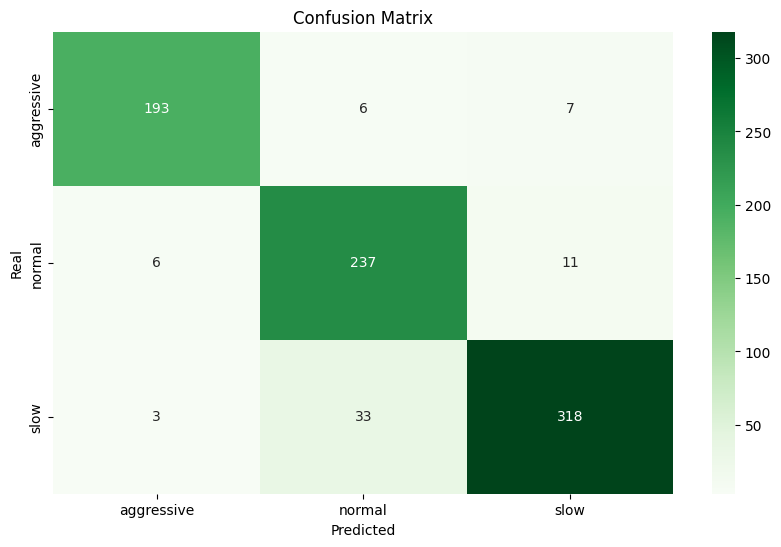

In [25]:
from sklearn import metrics
import seaborn as sns
import matplotlib.pyplot as plt

y_pred = model.evaluate(X_test)
print(f'Loss: {y_pred[0]}')
print(f'Accuracy: {y_pred[1]}')

# Simple confusion matrix
pred = model.predict(X_test)
pred = np.argmax(pred, axis=1)


conf_matrix = metrics.confusion_matrix(y_test, pred)
print(conf_matrix)

# Graphical confusion matrix
conf_matrix = metrics.confusion_matrix(y_test, pred)

plt.figure(figsize=(10, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Greens', xticklabels=label_names, yticklabels=label_names)
plt.xlabel('Predicted')
plt.ylabel('Real')
plt.title('Confusion Matrix')
plt.show()























## Performance Metrics

- Accuracy  $\large = \frac{Correct~Predictions}{All~Predictions}$
- Precision for a given class  $\large = \frac{Correct~Predictions~for~the~Class}{All~Predictions~for~the~Class}$   
- Recall for a given class  $\large = \frac{Correct~Predictions~for~the~Class}{All~Instances~of~the~Class}$  
- F1 Score $\large = \frac{2 \times \text{Precision} \times \text{Recall}}{\text{Precision} + \text{Recall}}$  
- Hamming Loss $\large = \frac{1}{N} \sum_{i=1}^{N} \frac{\text{Incorrect Labels}}{\text{Total Labels}}$  
- Jaccard Score $\large = \frac{|Y_{pred} \cap Y_{true}|}{|Y_{pred} \cup Y_{true}|}$  



- Averaging is a way to get a single number for multiclass. Depending on the importance one wants to give to minority classes: 
    - Macro average: Compute the metric for each class, and returns the average without considering the proportion for each class in the dataset. For instance:

        Precision = $\large = \frac{P_{class 1} ~+~ P_{class 2} ~+~ ... ~+~ P_{class n}}{N}$   
    
    - Weighted average: Compute the metric for each class, and returns the average considering the proportion (weighted) for each class in the dataset. For instance:

        Precision = $\large = \frac{N_1 ~*~ P_{class 1} ~+~ N_2 ~*~ P_{class 2} ~+~ ... ~+~ N_n ~*~ P_{class n}}{N}$

In [22]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Calculates performance metrics
acc = accuracy_score(y_true =  y_test, y_pred = pred)
print(f'Accuracy : {np.round(acc*100,2)}%')
          
precision = precision_score(y_true =  y_test, y_pred = pred, average='macro')
print(f'Precision - Macro: {np.round(precision*100,2)}%')

recall = recall_score(y_true =  y_test, y_pred = pred, average='macro')
print(f'Recall - Macro: {np.round(recall*100,2)}%')

f1 = f1_score(y_true =  y_test, y_pred = pred, average='macro')
print(f'F1-score - Macro: {np.round(f1*100,2)}%')

print()

precision = precision_score(y_true =  y_test, y_pred = pred, average='weighted')
print(f'Precision - Weighted: {np.round(precision*100,2)}%')

recall = recall_score(y_true =  y_test, y_pred = pred, average='weighted')
print(f'Recall - Weighted: {np.round(recall*100,2)}%')

f1 = f1_score(y_true =  y_test, y_pred = pred, average='weighted')
print(f'F1-score - Weighted: {np.round(f1*100,2)}%')

Accuracy : 91.89%
Precision - Macro: 92.02%
Recall - Macro: 92.28%
F1-score - Macro: 92.07%

Precision - Weighted: 92.13%
Recall - Weighted: 91.89%
F1-score - Weighted: 91.93%


In [23]:
from sklearn.metrics import classification_report

# Classification report
print(classification_report(y_test, pred, target_names=label_names))

              precision    recall  f1-score   support

  aggressive       0.96      0.94      0.95       206
      normal       0.86      0.93      0.89       254
        slow       0.95      0.90      0.92       354

    accuracy                           0.92       814
   macro avg       0.92      0.92      0.92       814
weighted avg       0.92      0.92      0.92       814



Error rate for class aggressive: 0.06311
Accuracy rate for class aggressive: 0.93689
Error rate for class normal: 0.06693
Accuracy rate for class normal: 0.93307
Error rate for class slow: 0.10169
Accuracy rate for class slow: 0.89831


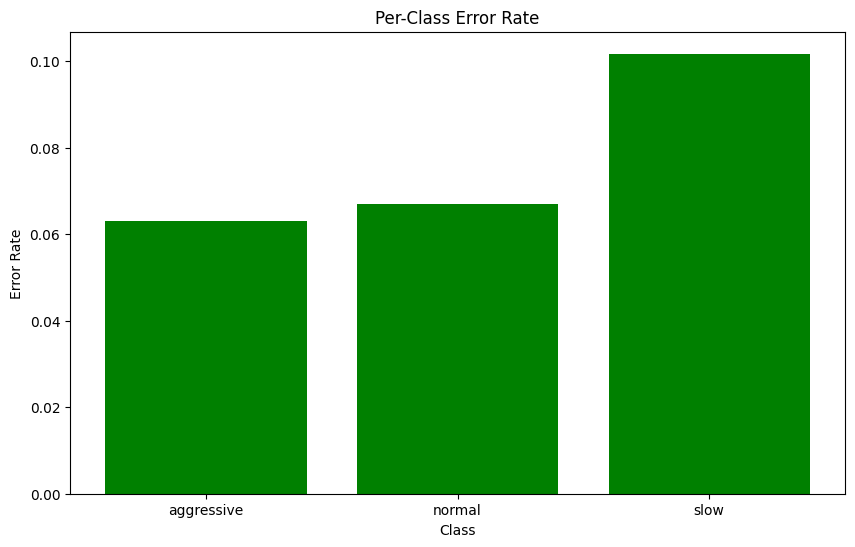

Mean per-class error: 0.07724


In [24]:
from sklearn.metrics import confusion_matrix
import numpy as np

# Assume y_test is the true labels and pred is the predicted labels
conf_matrix = confusion_matrix(y_test, pred)

# Calculate per-class accuracy
per_class_accuracy = conf_matrix.diagonal() / conf_matrix.sum(axis=1)

# Convert per-class accuracy to per-class error
per_class_error = 1 - per_class_accuracy

# Display per-class error
for idx, class_name in enumerate(label_names):
    print(f"Error rate for class {class_name}: {per_class_error[idx]:.5f}")
    # print accuracy
    print(f"Accuracy rate for class {class_name}: {per_class_accuracy[idx]:.5f}")

# Optional: You can plot the per-class error using matplotlib
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.bar(label_names, per_class_error, color='green')
plt.xlabel('Class')
plt.ylabel('Error Rate')
plt.title('Per-Class Error Rate')
plt.show()

# Mean per-class error
mean_per_class_error = np.mean(per_class_error)
print(f"Mean per-class error: {mean_per_class_error:.5f}")
